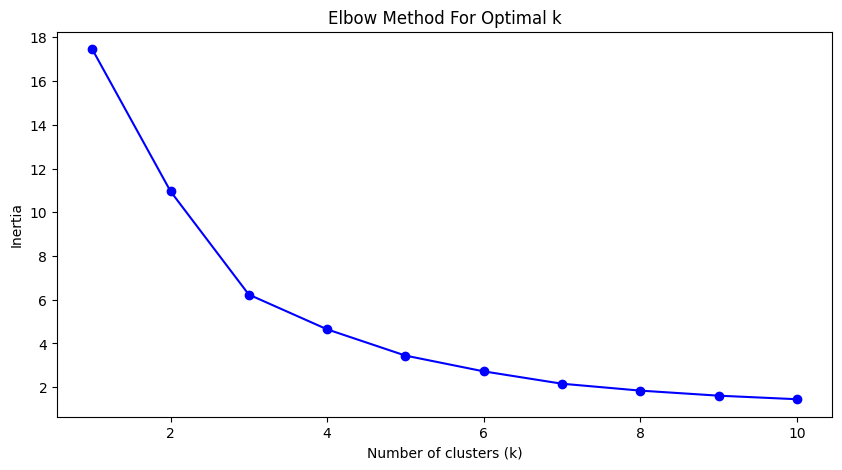

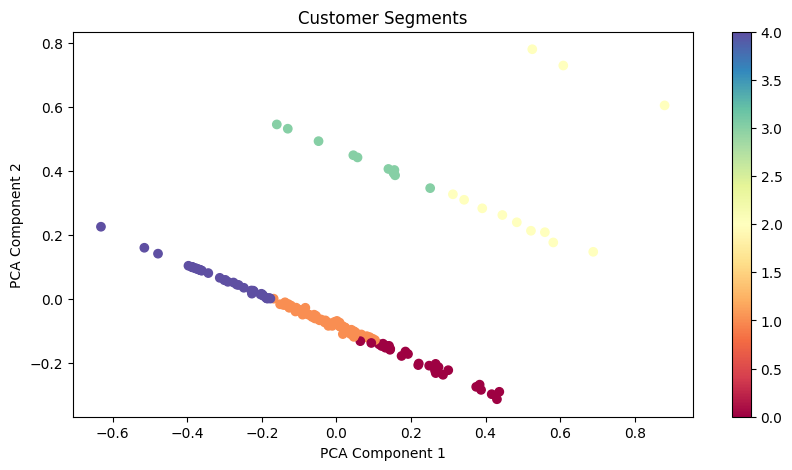

   NumPurchases  TotalQuantity  TotalSpending
0          1.00     223.100000     377.876333
1          1.00     102.533333     239.593200
2          2.25     192.750000     439.658333
3          2.00      66.200000     142.321000
4          1.00      16.666667      36.622564
Cluster 0 Characteristics:
  - Average Number of Purchases: 1.00
  - Average Total Quantity Purchased: 223.10
  - Average Total Spending: $377.88

Cluster 1 Characteristics:
  - Average Number of Purchases: 1.00
  - Average Total Quantity Purchased: 102.53
  - Average Total Spending: $239.59

Cluster 2 Characteristics:
  - Average Number of Purchases: 2.25
  - Average Total Quantity Purchased: 192.75
  - Average Total Spending: $439.66

Cluster 3 Characteristics:
  - Average Number of Purchases: 2.00
  - Average Total Quantity Purchased: 66.20
  - Average Total Spending: $142.32

Cluster 4 Characteristics:
  - Average Number of Purchases: 1.00
  - Average Total Quantity Purchased: 16.67
  - Average Total Spending: 

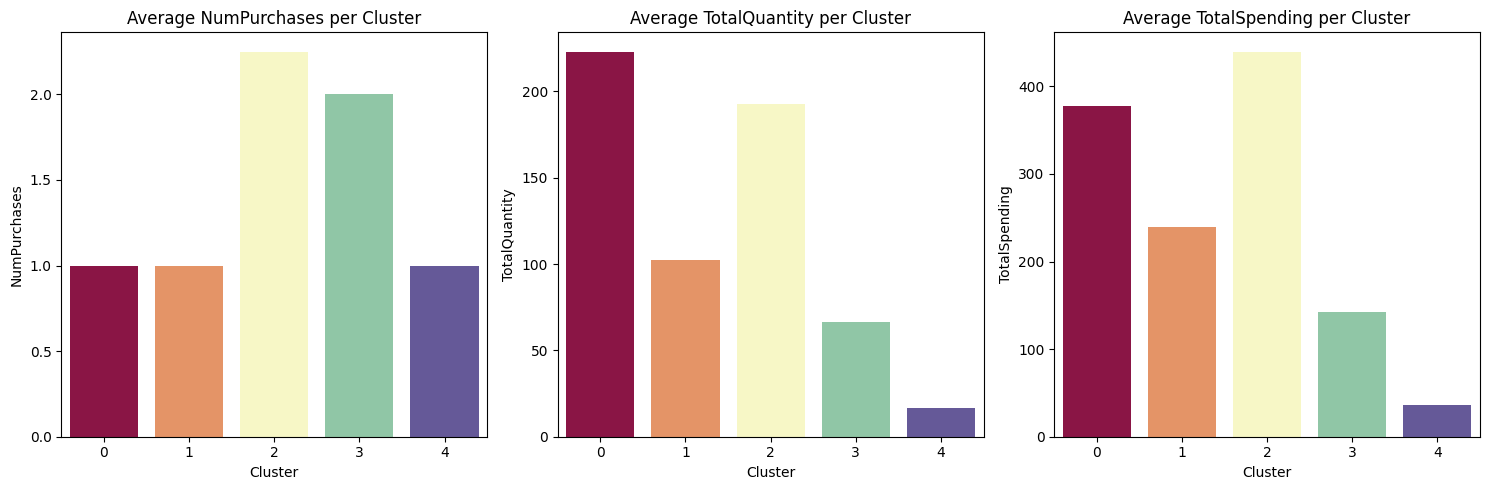

Cluster 0: Low spenders with a few purchases
Cluster 1: High spenders with frequent purchases
Cluster 2: Medium spenders with occasional purchases
Cluster 3: Low spenders with frequent small purchases
Cluster 4: Medium spenders with many purchases
Logistic Regression Accuracy: 0.97
Random Forest Accuracy: 1.00
Decision Tree Accuracy: 1.00
Best Model: RandomForestClassifier with Accuracy: 1.00
The new customer belongs to cluster 3
Input: {'NumPurchases': 1, 'TotalQuantity': 10, 'TotalSpending': 100}, Predicted Cluster: 4
Input: {'NumPurchases': 5, 'TotalQuantity': 50, 'TotalSpending': 500}, Predicted Cluster: 3
Input: {'NumPurchases': 10, 'TotalQuantity': 100, 'TotalSpending': 1000}, Predicted Cluster: 3
Input: {'NumPurchases': 15, 'TotalQuantity': 150, 'TotalSpending': 1500}, Predicted Cluster: 3
Input: {'NumPurchases': 20, 'TotalQuantity': 200, 'TotalSpending': 2000}, Predicted Cluster: 3
Input: {'NumPurchases': 25, 'TotalQuantity': 250, 'TotalSpending': 2500}, Predicted Cluster: 3


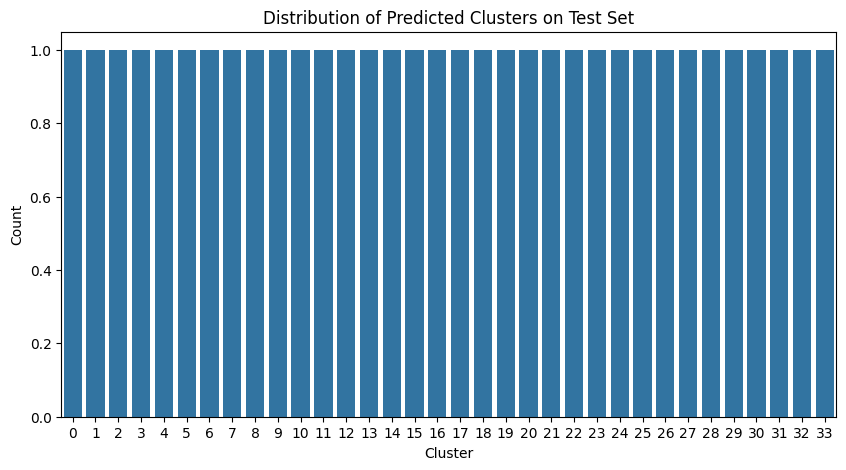

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import joblib
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

# Load the data
customers = pd.read_csv("customers.csv", nrows=5000)  # Adjust nrows as needed

# Data Cleaning
customers.drop_duplicates(inplace=True)

# Convert InvoiceDate to datetime
customers['InvoiceDate'] = pd.to_datetime(customers['InvoiceDate'])

# Handle missing CustomerID values
customers.dropna(subset=['CustomerID'], inplace=True)

# Derive total spending per invoice
customers['TotalPrice'] = customers['Quantity'] * customers['UnitPrice']

# Aggregate data by CustomerID to get features for clustering
customer_data = customers.groupby('CustomerID').agg({
    'InvoiceNo': 'nunique',  # Number of purchases
    'Quantity': 'sum',       # Total quantity purchased
    'TotalPrice': 'sum'      # Total spending
}).reset_index()

# Rename columns for clarity
customer_data.rename(columns={
    'InvoiceNo': 'NumPurchases',
    'Quantity': 'TotalQuantity',
    'TotalPrice': 'TotalSpending'
}, inplace=True)

# Handle outliers in TotalQuantity and TotalSpending
Q1 = customer_data[['TotalQuantity', 'TotalSpending']].quantile(0.25)
Q3 = customer_data[['TotalQuantity', 'TotalSpending']].quantile(0.75)
IQR = Q3 - Q1

# Filter out outliers
customer_data = customer_data[~((customer_data[['TotalQuantity', 'TotalSpending']] < (Q1 - 1.5 * IQR)) |
                                (customer_data[['TotalQuantity', 'TotalSpending']] > (Q3 + 1.5 * IQR))).any(axis=1)]

# Feature Scaling
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(customer_data.drop('CustomerID', axis=1))

# Determine the optimal number of clusters using the elbow method
inertia = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=0)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(k_range, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

# Apply KMeans clustering
optimal_k = 5  # Based on the elbow method
kmeans = KMeans(n_clusters=optimal_k, n_init=10, init='k-means++', max_iter=300, random_state=0)
customer_data['Cluster'] = kmeans.fit_predict(scaled_features)

# Dimensionality reduction using PCA
pca = PCA(n_components=2)
pca_2d = pca.fit_transform(scaled_features)

# Visualize the clusters
plt.figure(figsize=(10, 5))
plt.scatter(pca_2d[:, 0], pca_2d[:, 1], c=customer_data['Cluster'], cmap='Spectral')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Customer Segments')
plt.colorbar()
plt.show()

# Get the centroids of the clusters
centroids = kmeans.cluster_centers_

# Inverse transform the centroids to get them back to the original scale
centroids = scaler.inverse_transform(centroids)

# Create a DataFrame to display the centroids
centroids_df = pd.DataFrame(centroids, columns=['NumPurchases', 'TotalQuantity', 'TotalSpending'])

# Display the centroids
print(centroids_df)

# Interpretation of clusters based on centroids
for i, centroid in centroids_df.iterrows():
    print(f"Cluster {i} Characteristics:")
    print(f"  - Average Number of Purchases: {centroid['NumPurchases']:.2f}")
    print(f"  - Average Total Quantity Purchased: {centroid['TotalQuantity']:.2f}")
    print(f"  - Average Total Spending: ${centroid['TotalSpending']:.2f}")
    print()

# Bar plots for the average values of features in each cluster
cluster_summary = customer_data.groupby('Cluster').mean()

plt.figure(figsize=(15, 5))
for i, col in enumerate(['NumPurchases', 'TotalQuantity', 'TotalSpending']):
    plt.subplot(1, 3, i+1)
    sns.barplot(x=cluster_summary.index, y=cluster_summary[col], hue=cluster_summary.index, palette='Spectral', dodge=False, legend=False)
    plt.title(f'Average {col} per Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(col)
plt.tight_layout()
plt.show()

# Based on the centroids, you can interpret the clusters as follows:
# These are example interpretations. Adjust them according to your actual centroid values.

cluster_descriptions = {
    0: "Low spenders with a few purchases",
    1: "High spenders with frequent purchases",
    2: "Medium spenders with occasional purchases",
    3: "Low spenders with frequent small purchases",
    4: "Medium spenders with many purchases"
}

# Print cluster descriptions
for cluster_id, description in cluster_descriptions.items():
    print(f"Cluster {cluster_id}: {description}")

# Splitting the data for model training
X = customer_data.drop(['CustomerID', 'Cluster'], axis=1)
y = customer_data['Cluster']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training and evaluating models
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier()
}

best_accuracy = 0
best_model = None

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {accuracy:.2f}")
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model

print(f"Best Model: {best_model.__class__.__name__} with Accuracy: {best_accuracy:.2f}")

# Save the best model
joblib.dump(best_model, 'best_model.pkl')
# Save the scaler object
joblib.dump(scaler, 'scaler.pkl')

# Function to predict the cluster for a new customer
def predict_cluster(new_data):
    # Ensure new_data is a DataFrame
    if isinstance(new_data, dict):
        new_data = pd.DataFrame([new_data])

    # Align the new data columns with the expected features
    required_features = ['NumPurchases', 'TotalQuantity', 'TotalSpending']
    new_data = new_data[required_features]

    # Ensure proper scaling using the same scaler as during training
    new_data_scaled = scaler.transform(new_data)

    # Predict the cluster
    cluster = best_model.predict(new_data_scaled)
    return cluster[0]

# Example usage with debug prints
new_customer = {
    'NumPurchases': 5,
    'TotalQuantity': 20,
    'TotalSpending': 300
}
predicted_cluster = predict_cluster(new_customer)
print(f'The new customer belongs to cluster {predicted_cluster}')

# Check the distribution of predicted clusters for a range of inputs
test_customers = pd.DataFrame({
    'NumPurchases': [1, 5, 10, 15, 20, 25],
    'TotalQuantity': [10, 50, 100, 150, 200, 250],
    'TotalSpending': [100, 500, 1000, 1500, 2000, 2500]
})

for _, row in test_customers.iterrows():
    cluster = predict_cluster(row.to_frame().T)
    print(f"Input: {row.to_dict()}, Predicted Cluster: {cluster}")

# Check the cluster distribution for test set predictions
y_test_pred = best_model.predict(X_test)
plt.figure(figsize=(10, 5))
sns.countplot(y_test_pred)
plt.title('Distribution of Predicted Clusters on Test Set')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()
